# Conservation 

In [2]:
# many functions have been defined but written down in different ipynb files, for clarity. Import those (%run)
%run Functions.ipynb
%run Functions_visualization.ipynb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

### Conservation WITHIN clades

For conservation studies, we require the peptide sequence of those with strong enough binding affinity to HLA alleles rather than merely the count of the number of peptides presented

In [32]:
%store -r proteins_grouped

# Generate a new dictionary based on the same dictionary as used previously (proteins_grouped) 
# but store the peptide seq instead of the 'binders'
# cutoff for a peptide being bound by HLA is 2.0 
peptideseqs = to_dict_peptideseqs_grouped(proteins_grouped, 2.0) 

# Add additional layer of hierarchy in grouped_abs dictionary, 
# grouping reference strains together when belonging to the same clade
peptideseqs_clades = add_clades(peptideseqs)
%store peptideseqs_clades

gag acc pol envStored 'peptideseqs_clades' (dict)



For each clade, we compare the presented peptides (binders) for each HLA allele and count whether that same peptide also occurs in the other reference strains from this clade. If so, we call this peptide more conserved conservation score is thus defined as the no. of other strains within a clade in which a certain peptides co-occurs HIV1-A1 has only 3 reference strains, thus the max conservation score is 2, for HIV1-B and HIV1-C the max is 3   
conserved_epis_within_2[allele][protein][clade] thus yields list of conserved epitopes, therefore, len(conserved_epis_within_2[allele][protein][clade]) yield the amount of conserved epitopes. 

In [33]:
%store -r peptideseqs_clades

# peptideseqs_clades is input, cutoff is set at 2 or 3. Cutoff 0 generates dict with all peptides, used as 100% measure
conserved_epis_within_0 = conserved_epitopes_within(peptideseqs_clades, 0.0)
conserved_epis_within_2 = conserved_epitopes_within(peptideseqs_clades, 2.0)
conserved_epis_within_3 = conserved_epitopes_within(peptideseqs_clades, 3.0)

In [34]:
%store -r protection_score

def sum_conserved(allele, clade): # calculates the amount of conserved epitopes summed for all proteins
    if clade == 'HIV1-A1':
        result = sum([float(len(pd.DataFrame(conserved_epis_within_2[allele][protein][clade]))) for protein in ['acc','pol','env','gag']])
    else:
        result = sum([float(len(pd.DataFrame(conserved_epis_within_3[allele][protein][clade]))) for protein in ['acc','pol','env','gag']])
    return result

def sum_total(allele, clade): # calculates the total number of presented epitopes for all proteins (100%)
    return sum([len(pd.DataFrame(conserved_epis_within_0[allele][protein][clade])) for protein in ['acc','pol','env','gag']])
    
# calculate % conservation within a clade for each allele, as defined by sum_conserved / sum_total (see above)
conservation_within = {clade:{allele: sum_conserved(allele, clade)/sum_total(allele, clade)*100 
                              for allele in conserved_epis_within_0.keys()}
                       for clade in ['HIV1-A1','HIV1-B','HIV1-C']}

# HLA-B18:05 has ambigious protection, so leave out this allele
conservation_within['HIV1-A1']['HLA-B18:01'] = 0.0
conservation_within['HIV1-B']['HLA-B18:01'] = 0.0
conservation_within['HIV1-C']['HLA-B18:01'] = 0.0

HIV1-A1
MannwhitneyuResult(statistic=64.0, pvalue=0.33556272919490637)


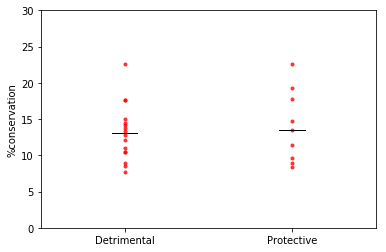

HIV1-B
MannwhitneyuResult(statistic=80.0, pvalue=0.68485201402887563)


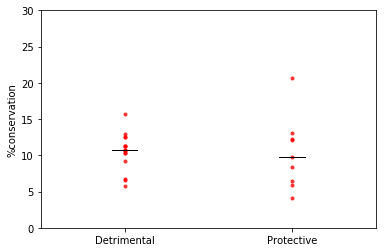

HIV1-C
MannwhitneyuResult(statistic=86.0, pvalue=0.79414862649707652)


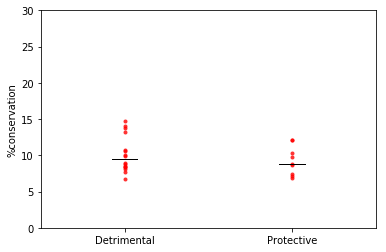

In [35]:
# per HIV clade, prepare conservation_within dataframe into format that can be used for plotting, 
# and perform MannWhitneyU test (unpaired, non-parametrical, one-sided)
ABC = {}
for clade in conservation_within:
    df = scatterplot_matrixprep(conservation_within[clade], 'conservation')
    ABC[clade] = df

for clade in 'HIV1-A1','HIV1-B','HIV1-C':
    print clade
    scatter_dot_plot_mannwhitney(ABC[clade], 'conservation', '%conservation', 0, 30)

### Conservation AMONG ALL strains, irrespective of clade

Secondly, we discard the clustering into clades and assess conservation of the presented epitopes across all strains/clades of HIV1

In [42]:
%store -r proteins_grouped

# use proteins_grouped dict as input, cutoff for peptide binding at 2.0. 
# We do not add the extra level of clade hierarchy, but do select for HIV1 strains only
peptideseqs_temp = to_dict_peptideseqs_grouped(proteins_grouped, 2.0)
peptideseqs_df = pd.DataFrame(peptideseqs_temp).transpose()
HIV1 = [strain for strain in peptideseqs_temp['acc'].keys() if strain.startswith('Ref')]
peptideseqs_HIV1 = {strain: peptideseqs_df[strain] for strain in HIV1} 
peptideseqs = dict_transpose_ABC_CAB(dict_transpose_AB_BA(peptideseqs_HIV1))

 gag acc pol env


Firstly combine all epitopes from entire HIVproteome, and assess conservation per HLA allele in total

Stored 'conserved_epis_all' (dict)
MannwhitneyuResult(statistic=74.0, pvalue=0.55627619740984713)


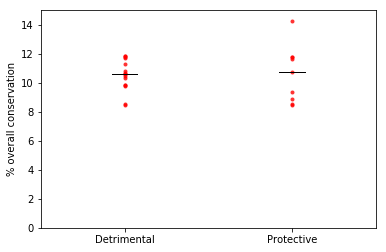

In [46]:
conserved_epis_all = conserved_epitopes_all(peptideseqs, 0.0)
%store conserved_epis_all

# take mean of conservation scores for all epitopes from all proteins, per allele
overall_conservation = {} # initiate
for allele in conserved_epis_all: # per allele
    strainmeans = [] # initiate
    for strain in conserved_epis_all[allele]['env']: # per strain
        ref1 = [(conserved_epis_all[allele][protein][strain].values()) # get list of conservation scores of all epitopes
               for protein in 'env','pol','gag','acc'] # for each protein, creates nested list
        ref1_mean = np.mean([item for sublist in ref1 for item in sublist]) # unzip nested list and take mean of all 
        #print strain, ref1_mean
        strainmeans.append(ref1_mean) # append mean conservation for this strain to list for all strains
    overall_conservation[allele] = np.mean(strainmeans) # take mean of all strains = one final conservation score per allele
    
df = scatterplot_matrixprep(overall_conservation, 'conservation') # prepare conservation_within dataframe into format that can be used for plotting,
#print df
scatter_dot_plot_mannwhitney(df, 'conservation', '% overall conservation', 0, 15) # plot and perform one-sided MannWhitney U

### Conservation among all strains/clades, per protein

acc
MannwhitneyuResult(statistic=87.0, pvalue=0.8098964314063134)


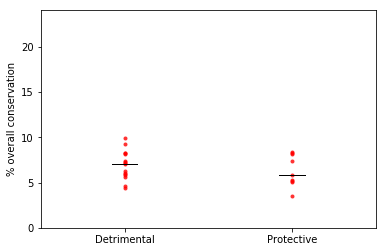

gag
MannwhitneyuResult(statistic=73.0, pvalue=0.53383781332583335)


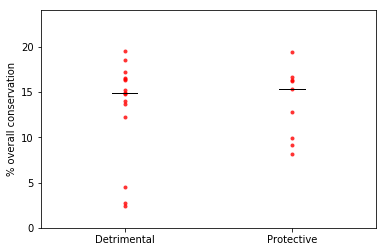

pol
MannwhitneyuResult(statistic=44.0, pvalue=0.059749379895022721)


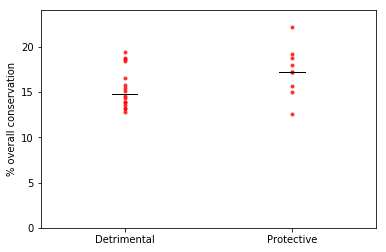

env
MannwhitneyuResult(statistic=73.0, pvalue=0.53383781332583335)


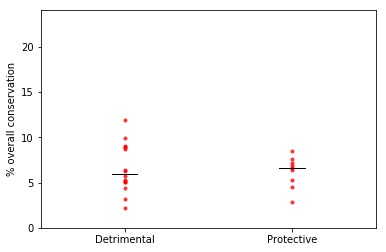

In [3]:
%store -r conserved_epis_all
overall_conservation_pp = {}
for allele in conserved_epis_all: # similar to above, for each allele
    protmeans = {} # initiate
    for protein in 'env','pol','gag','acc': # this time, don't add up entire proteome, but leave separated
        strainmeans = [] # initiate
        for strain in conserved_epis_all[allele][protein]: # for each strain
            x = conserved_epis_all[allele][protein][strain].values() # make list of conservation scores of epitopes
            if len(x) > 0: # we have one allele/strain/protein combination that doesn't yield any presented peptides, which would interfere with further calculations
                strainmeans.append(np.mean(x)) # take mean of conservation scores of epitopes
        protmeans[protein] = np.mean(strainmeans) # take mean of conservation scores per strain, into one per protein
    overall_conservation_pp[allele] = protmeans # store in final dictionary: mean conservation score per allele, per protein
overall_conservation_pp = dict_transpose_AB_BA(overall_conservation_pp) # reorganise into proper format for further processing

for protein in overall_conservation_pp: # prep data for plotting and perform MannWhitneyU, one-sided
    print protein
    df = scatterplot_matrixprep(overall_conservation_pp[protein], 'conservation')
    #print df
    scatter_dot_plot_mannwhitney(df, 'conservation', '% overall conservation', 0, 24)

acc
MannwhitneyuResult(statistic=66.0, pvalue=0.37775732836942111)


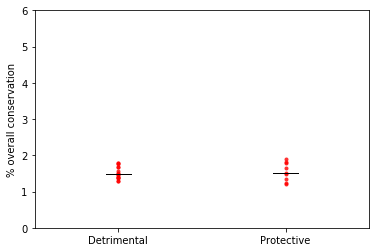

gag
MannwhitneyuResult(statistic=55.0, pvalue=0.17511879240949707)


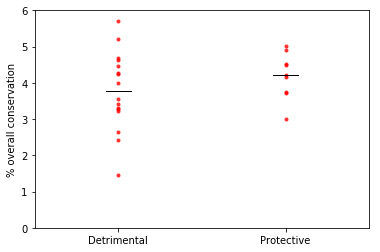

pol
MannwhitneyuResult(statistic=41.0, pvalue=0.042108758455744487)


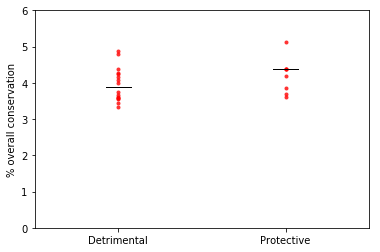

env
MannwhitneyuResult(statistic=69.0, pvalue=0.44372380259015287)


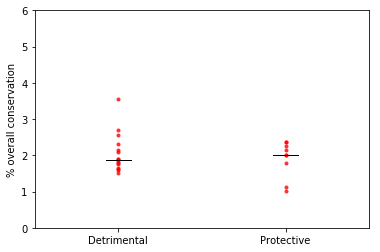

In [39]:
## Below is old scenario in which only HIV1-A1, HIV1-B, HIV1-C, HIV2-A and HIV2-B are taken along into conservation assessment
# If to be run again; change first section in this paragraph to select strains from Reflist instead of strains from HIV1
# same code as above
overall_conservation_pp = {}
for allele in conserved_epis_all:
    protmeans = {}
    for protein in 'env','pol','gag','acc':
        strainmeans = []
        for strain in conserved_epis_all[allele][protein]:
            x = conserved_epis_all[allele][protein][strain].values()
            if len(x) > 0:
                strainmeans.append(np.mean(x))
        protmeans[protein] = np.mean(strainmeans)
    overall_conservation_pp[allele] = protmeans
overall_conservation_pp = dict_transpose_AB_BA(overall_conservation_pp)

for protein in overall_conservation_pp:
    df = scatterplot_matrixprep(overall_conservation_pp[protein], 'conservation')
    print protein
    scatter_dot_plot_mannwhitney(df, 'conservation', '% overall conservation', 0, 6)